<p style='font-family: times, serif; font-size:25pt; font-style:bold; color:black;'>
    BlueMath - SHyTCWaves
</p>

<p style='font-family: times, serif; font-size:16pt; font-style:bold; color:black;'>
    Non-stationary SWAN: <u>historical</u> TC into 6h-segments
</p>

<hr size="5"/>

<span style='font-family: times, arial; font-size:14pt; font-weight:bold; color:black;'> Table of Contents </span>

* [1. Load data (from preprocessing nb)](#1.-Load-data-(from-preprocessing-nb))


* [2. SWAN project](#2.-SWAN-project)
    * [2.1 SWAN main mesh](#2.1-SWAN-main-mesh)
    * [2.2 SWAN nested mesh](#2.2-SWAN-nested-mesh)
    * [2.3 SWAN case parameters](#2.3-SWAN-case-parameters)
    * [2.4 SWAN input: storm track, no waves](#2.4-SWAN-input:-storm-track,-no-waves)


* [3. Plot site configuration](#3.-Plot-site-configuration)


* [4. SWAN WRAP](#4.-SWAN-WRAP)
    * [4.1 Build cases](#4.1-Build-cases)
        * [Plot input: Vortex winds](#Plot-input:-Vortex-winds)
        * [Plot input: Graffiti maximum winds](#Plot-input:-Graffiti-maximum-winds)
    * [4.2 Run cases](#4.2-Run-cases)
        * [Plot output: Hsig](#Plot-output:-Hsig)
        * [Plot output: Graffiti maximum Hsig](#Plot-output:-Graffiti-maximum-Hsig)
        * [Plot output: Control Point time series](#Plot-output:-Control-Point-time-series)
    * [4.3 Extract output](#4.3-Extract-output)

<br>

<div class="alert alert-block alert-warning">
    
<b>Info:</b> this notebook imports SWAN input data (from preprocessing nb), defines SWAN configuration and meshes, builds and runs SWAN case. </div>

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

# dev library
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', 'hywaves'))

# swan wrap module
from hywaves.swan.wrap import SwanProject, SwanMesh, SwanWrap_NONSTAT
from hywaves.swan.storms import historic_track_preprocessing, historic_track_interpolation
from hywaves.swan.stopmotion import storm2stopmotion, stopmotion_interpolation

# plotting
from hywaves.swan.plots.nonstationary import plot_project_site, plot_case_input, \
plot_case_output_grafiti, plot_case_vortex_grafiti, plot_case_output_points, \
plot_case_vortex_input, plot_case_output, plot_matrix_input, plot_matrix_grafiti


##  **1. Load data (from preprocessing nb)**

In [2]:
site = 'Samoa'

# path data
p_data = op.abspath(op.join(os.path.abspath(''), '..', 'data'))
p_input = op.join(p_data, 'sites', site)

# load storm
name = 'OFA'
storm = xr.open_dataset(op.join(p_input, 'storm_ibtracs_{0}_{1}.nc'.format(name, site)))

##  **2. SWAN project**

In [3]:
p_proj = op.join(p_data, 'projects')  # swan projects main directory
n_proj = 'nb_00_stopmotion'                  # project name

sp = SwanProject(p_proj, n_proj)

###  **2.1 SWAN main mesh**

In [4]:
# NOTE: cartesian coordinates convention

# computational grid description
res = 15*10**3   # km to m
xlength, ylength = 1500*10**3, 1500*10**3    # km to m

# create domain centered at (x,y)=(0,0)
lon = np.arange(-xlength/2, xlength/2, res)
lat = np.arange(-ylength/2, ylength/2, res)

# create uniform bathymetry (deep waters, -1000m)
depth = 1000 * np.ones((lon.size, lat.size))


# SwanMesh object
main_mesh = SwanMesh()

# depth grid description (input bathymetry grid)
main_mesh.dg = {
    'xpc': lon[0],                             # x origin
    'ypc': lat[0],                             # y origin
    'alpc': 0,                                 # x-axis direction 
    'xlenc': lon[-1]-lon[0],                   # grid length in x
    'ylenc': lat[-1]-lat[0],                   # grid length in y
    'mxc': depth.shape[1]-1,                   # number mesh x
    'myc': depth.shape[0]-1,                   # number mesh y
    'dxinp': (lon[-1]-lon[0])/depth.shape[1],  # size mesh x
    'dyinp': (lat[-1]-lat[0])/depth.shape[0],  # size mesh y
}

# mesh orientation (for SWAN model)
main_mesh.dg_idla = 3

# depth value (from file)
main_mesh.depth = depth

# computational grid description
# res = 0.136  # (15km = 0.136º)  

main_mesh.cg = {
    'xpc': lon[0],
    'ypc': lat[0],
    'alpc': 0,
    'xlenc': lon[-1]-lon[0],
    'ylenc': lat[-1]-lat[0],
    'mxc': int((lon[-1]-lon[0])/res),
    'myc': int((lat[-1]-lat[0])/res),
    'dxinp': (lon[-1]-lon[0]) / int((lon[-1]-lon[0])/res),
    'dyinp': (lat[-1]-lat[0]) / int((lat[-1]-lat[0])/res),
}

sp.set_main_mesh(main_mesh)

###  **2.3 SWAN case parameters**

In [5]:
input_params = {
    'set_level': 0,
    'set_convention': 'NAUTICAL',   # angle convention for wind/waves
    'set_cdcap': 2.5*10**-3,

    'coords_mode': 'CARTESIAN',#'SPHERICAL',
    'coords_projection': '',#'CCM',

    'boundw_jonswap': 3.3,
    'boundw_period': 'MEAN',
    
    'boundn_mode':'CLOSED',

    'wind_deltinp': '20 MIN',
    'level_deltinp': '1 HR',

    'compute_deltc': '20 MIN',
    'output_deltt': '1 HR',      # MUST BE MULTIPLE OF 'compute_deltc'
    
#     'output_points_x': [187.2, 190.9459, 188.2099, 181.3700],    # Samoa, NE, SW, W
#     'output_points_y': [-13.35, -9.0125, -18.6247, -18.6247],

#     'output_points_spec': True,
    
    'physics':[
        'WIND DRAG WU',
        'GEN3 ST6 5.7E-7 8.0E-6 4.0 4.0 UP HWANG VECTAU TRUE10',
        'QUAD iquad=8',
        'WCAP',
        #'SETUP',  # not compatible with spherical coords
        'TRIADS',
        'DIFFRAC',
    ],
    
    'numerics':[
        'PROP BSBT',
    ],

    'output_variables': ['HSIGN', 'DIR', 'PDIR', 'TM02', 'TPS', 'DSPR', 'WATLEV', 'WIND', 'OUT'],
    
    'output_spec': True,  # Block output spectra: SPECOUT 'COMPGRID' SPEC2D ABS 'output_spec.nc' OUT 19900203.0400 20 MIN
    'output_spec_deltt': '1 HR',
    
#    'output_time_ini': 24,?????
    
}
sp.set_params(input_params)

###  **2.4 SWAN input: storm track, no waves**

In [6]:
# target coordinates
target = 'Samoa'
x0, y0 = -172.8, -13.5

# load bathymetry
xds_bathy = xr.open_dataset(op.join(p_input, 'depth_{0}.nc'.format(site)))

# get variables from main bathymetry 
lon = xds_bathy.lon.values[:]
lat = xds_bathy.lat.values[:]


# preprocess storm variables (Ibtracs v4)
d_vns = {
    'longitude': 'lon',
    'latitude': 'lat',
    'time': 'time',
    'pressure': 'wmo_pres',
    'maxwinds': 'wmo_wind',
    'rmw': None,
}

st_time, ylat_tc, ylon_tc, ycpres, ywind, ts, categ, vmean = historic_track_preprocessing(storm, d_vns)


# STOPMOTION, 6h intervals/segments
dt_interp = 60*6       # minutes

# generate interpolated storm track  
st, time_input = historic_track_interpolation(
    st_time, ylon_tc, ylat_tc, ycpres, ywind,
    y0, x0, lat[0], lon[0], lat[-1], lon[-1],  
    ts, dt_interp, wind=ywind,
    great_circle=True, interpolation=False, mode='mean',    # NO INTERPOLATION
)

# # [OPTIONAL] override SWAN storm case computational delta time (compute_deltc) parameter
# st.attrs['override_dtcomp'] = '{0} MIN'.format(dt_interp)

## generate empty wave event
we = pd.DataFrame(index=time_input, columns=['hs', 't02', 'dir', 'spr', 'U10', 'V10'])
we['level'] = 0
we['tide'] = 0

In [7]:
st   # move(º) vf(kt) p0(mbar) vmax(kt)

,move,vf,vfx,vfy,pn,p0,lon,lat,vmax
1990-01-30 00:00:00,223.197158,2.946963,2.017229,2.148344,1013,996.0,180.122223,-8.033334,32.5
1990-01-30 06:00:00,223.197158,2.946963,2.017229,2.148344,1013,996.0,180.327654,-7.815098,32.5
1990-01-30 12:00:00,281.364626,3.340136,3.274646,-0.658181,1013,992.5,180.533325,-7.600000,37.5
1990-01-30 18:00:00,281.364626,3.340136,3.274646,-0.658181,1013,992.5,180.866694,-7.666717,37.5
1990-01-31 00:00:00,305.438242,3.415284,2.782571,-1.980267,1013,988.5,181.199997,-7.733334,42.5
1990-01-31 06:00:00,305.438242,3.415284,2.782571,-1.980267,1013,988.5,181.483450,-7.934355,42.5
1990-01-31 12:00:00,308.925927,4.204170,3.270671,-2.641544,1013,986.0,181.766663,-8.133333,47.5
1990-01-31 18:00:00,296.790453,4.393199,3.921637,-1.980142,1013,985.0,182.100021,-8.400001,50.0
1990-02-01 00:00:00,291.993138,5.284296,4.899751,-1.978945,1013,982.5,182.500000,-8.599999,52.5
1990-02-01 06:00:00,309.606105,4.661086,3.591112,-2.971471,1013,980.0,183.000000,-8.800000,55.0


**STOP-MOTION: generate independent consecutive segments {P,dP,V,dV,W,dW,R,dR,lat,dAng}**

In [8]:
# load pmin-vmax polynomial fitting coefficients
xds_coef = xr.open_dataset(r'/media/administrador/Disco/GitLab/BlueMath/notebooks/ibtracs_coef_basins_centers.nc')

# generate stopmotion segments (warmup+target variables)
d_vns_df = {
    'longitude': 'lon',
    'latitude': 'lat',
    'time': 'time',
    'pressure': 'p0',
    'maxwinds': 'vmax',
    'rmw': None,
}

df_seg = storm2stopmotion(st, d_vns_df, xds_coef, var=['pressure','wind'], varfill=['rmw'])
df_seg[:10]

,time,longitude,latitude,pressure,wind,rmw,pseg,wseg,lseg,laseg,...,aseg,dpseg,dwseg,dlseg,dlaseg,drseg,dvseg,dvxseg,dvyseg,daseg
time,,,,,,,,,,,,,,,,,,,,,
1990-01-30 00:00:00,1990-01-30 00:00:00,180.122223,-8.033334,996.0,32.5,43.225866,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-30 06:00:00,1990-01-30 06:00:00,180.327654,-7.815098,996.0,32.5,43.149458,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-30 12:00:00,1990-01-30 12:00:00,180.533325,-7.600000,992.5,37.5,39.551719,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-30 18:00:00,1990-01-30 18:00:00,180.866694,-7.666717,992.5,37.5,39.574226,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-31 00:00:00,1990-01-31 00:00:00,181.199997,-7.733334,988.5,42.5,36.359009,990.50,40.00,-7.700025,7.700025,...,101.425103,-2.00,2.50,-0.133819,0.133819,-1.572817,1.263657,0.261149,-5.125665,-51.238213
1990-01-31 06:00:00,1990-01-31 06:00:00,181.483450,-7.934355,988.5,42.5,36.428593,988.50,42.50,-7.833844,7.833844,...,125.616831,-1.25,2.50,-0.200000,0.200000,-1.414088,1.040472,-0.106934,-3.144105,-29.351357
1990-01-31 12:00:00,1990-01-31 12:00:00,181.766663,-8.133333,986.0,47.5,33.530833,987.25,45.00,-8.033844,8.033844,...,125.377011,-1.75,3.75,-0.232823,0.232823,-2.094423,1.687044,0.452274,-2.479651,-15.307186
1990-01-31 18:00:00,1990-01-31 18:00:00,182.100021,-8.400001,985.0,50.0,32.239747,985.50,48.75,-8.266667,8.266667,...,128.973858,-1.75,2.50,-0.233333,0.233333,-1.271717,1.617004,1.671739,-0.314285,4.218139
1990-02-01 00:00:00,1990-02-01 00:00:00,182.500000,-8.599999,982.5,52.5,30.987399,983.75,51.25,-8.500000,8.500000,...,116.849574,-2.50,2.50,-0.200000,0.200000,-1.222060,2.696122,3.197140,0.305481,11.982224


In [9]:
df_seg.keys()

Index(['time', 'longitude', 'latitude', 'pressure', 'wind', 'rmw', 'pseg',
       'wseg', 'lseg', 'laseg', 'rseg', 'vsegwarm', 'vxsegwarm', 'vysegwarm',
       'asegwarm', 'vseg', 'vxseg', 'vyseg', 'aseg', 'dpseg', 'dwseg', 'dlseg',
       'dlaseg', 'drseg', 'dvseg', 'dvxseg', 'dvyseg', 'daseg'],
      dtype='object')

**STOP-MOTION: generate list of segment cases in a relative reference system (24h+6h+42h = 3 days)**

In [10]:
# st_list units: x(m), y(m), vf(kt), p0(mbar), vmax(kt), rmw(nmile), lat(º)
st_list, we_list = stopmotion_interpolation(df_seg, st)

# [OPTIONAL] override SWAN storm case computational delta time (compute_deltc) parameter
for i in range(len(st_list)):
    st_vmean = np.nanmean(st_list[i].vf.values)
    
    if st_vmean*1.852 < 20:      dt_comp = 20
    elif st_vmean*1.852 >= 20:   dt_comp = 10

    st_list[i].attrs['override_dtcomp'] = '{0} MIN'.format(dt_comp)
    st_list[i]['lon'] = st_list[i]['x']
    st_list[i]['lat'] = st_list[i]['y']

    st_list[i].x0 = 0
    st_list[i].y0 = 0


In [11]:
st_list[0]

,x,y,vf,vfx,vfy,pn,p0,vmax,rmw,lat,lon,latitude
2019-12-31 00:00:00,-123446.290134,0.0,2.777319,2.777319,0.0,1013,990.5,40.0,37.966618,0.0,-123446.290134,-7.833844
2019-12-31 00:20:00,-121731.758326,0.0,2.777319,2.777319,0.0,1013,990.5,40.0,37.966618,0.0,-121731.758326,-7.833844
2019-12-31 00:40:00,-120017.226519,0.0,2.777319,2.777319,0.0,1013,990.5,40.0,37.966618,0.0,-120017.226519,-7.833844
2019-12-31 01:00:00,-118302.694712,0.0,2.777319,2.777319,0.0,1013,990.5,40.0,37.966618,0.0,-118302.694712,-7.833844
2019-12-31 01:20:00,-116588.162904,0.0,2.777319,2.777319,0.0,1013,990.5,40.0,37.966618,0.0,-116588.162904,-7.833844
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-02 22:20:00,NaN,NaN,NaN,NaN,NaN,1013,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02 22:40:00,NaN,NaN,NaN,NaN,NaN,1013,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02 23:00:00,NaN,NaN,NaN,NaN,NaN,1013,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-02 23:20:00,NaN,NaN,NaN,NaN,NaN,1013,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
we_list[0]

,hs,t02,dir,spr,U10,V10,level,tide
2019-12-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2019-12-31 00:20:00,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2019-12-31 00:40:00,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2019-12-31 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2019-12-31 01:20:00,NaN,NaN,NaN,NaN,NaN,NaN,0,0
...,...,...,...,...,...,...,...,...
2020-01-02 22:20:00,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2020-01-02 22:40:00,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2020-01-02 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2020-01-02 23:20:00,NaN,NaN,NaN,NaN,NaN,NaN,0,0


In [13]:
len(we_list)

20

**Plot storm vs stopmotion segments**

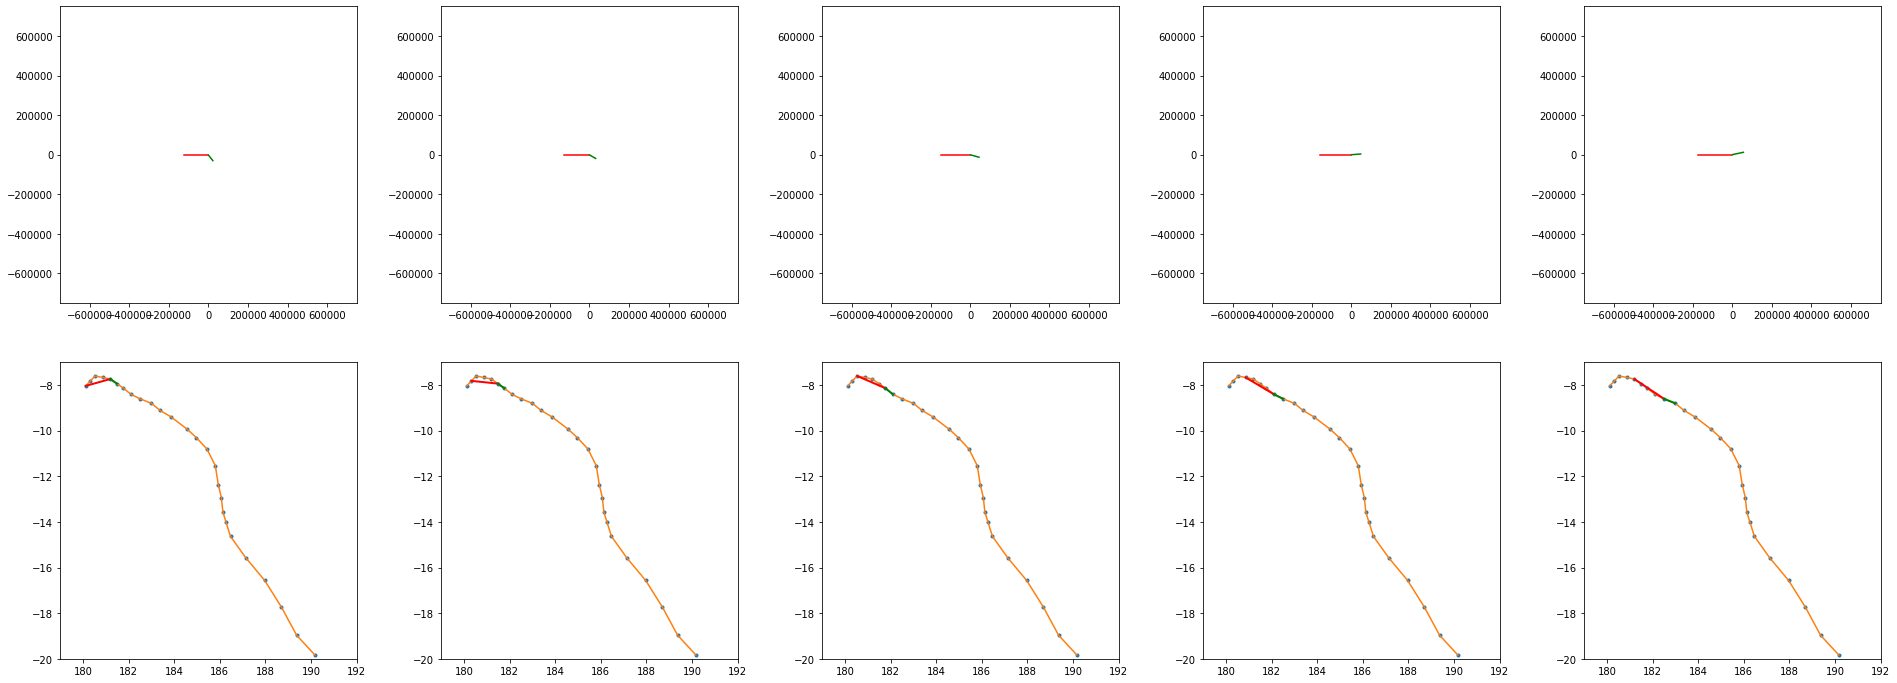

In [14]:
N = 5
for i in range(N):
    plt.subplot(2,N,i+1); plt.plot(st_list[i]['x'][:24*3], st_list[i]['y'][:24*3], 'r')
    plt.subplot(2,N,i+1); plt.plot(st_list[i]['x'][24*3:], st_list[i]['y'][24*3:], 'g'); 
    plt.axis('square'); plt.xlim([-xlength/2, xlength/2]); plt.ylim([-ylength/2, ylength/2]);
for i in range(N):
    plt.subplot(2,N,i+1+N); plt.plot(df_seg['longitude'], df_seg['latitude'], '.'); plt.plot(st['lon'], st['lat']);
    plt.plot([df_seg['longitude'].values[i], df_seg['longitude'].values[i+4]], [df_seg['latitude'].values[i], df_seg['latitude'].values[i+4]], 'r', linewidth=2)
    plt.plot([df_seg['longitude'].values[i+4], df_seg['longitude'].values[i+5]], [df_seg['latitude'].values[i+4], df_seg['latitude'].values[i+5]], 'g', linewidth=2)
    plt.axis('square'); plt.xlim([179,192]); plt.ylim([-20,-7])

plt.gcf().set_size_inches(22*1.5, 8*1.5)
# plt.savefig(op.join(p_figs, 'split_ofa_1.png'))

##  **3. Plot site configuration**

No handles with labels found to put in legend.


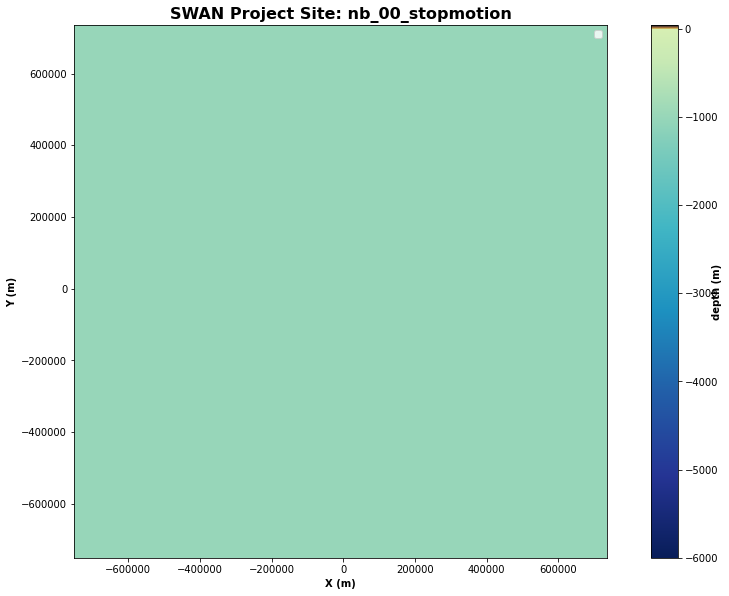

In [15]:
# plot site depth, control points, nested meshes (if any)
plot_project_site(sp, vmin=-6000, vmax=40);

##  **4. SWAN WRAP**

In [16]:
# SWAN project wrapper
sw = SwanWrap_NONSTAT(sp)


In [17]:
p_figs = op.join(p_proj, n_proj, 'output_figs')
if not op.isdir(p_figs): os.makedirs(p_figs)

###  **4.1 Build cases**

In [18]:
# build non-stationary cases from wave_events list and storm_tracks list
sw.build_cases(we_list, storm_track_list=st_list, make_waves=False, make_levels=False)

CASE 0000 - compute_deltc, wind_deltinp override with storm track: 20 MIN
CASE 0001 - compute_deltc, wind_deltinp override with storm track: 20 MIN
CASE 0002 - compute_deltc, wind_deltinp override with storm track: 20 MIN
CASE 0003 - compute_deltc, wind_deltinp override with storm track: 20 MIN
CASE 0004 - compute_deltc, wind_deltinp override with storm track: 20 MIN
CASE 0005 - compute_deltc, wind_deltinp override with storm track: 20 MIN
CASE 0006 - compute_deltc, wind_deltinp override with storm track: 20 MIN
CASE 0007 - compute_deltc, wind_deltinp override with storm track: 20 MIN
CASE 0008 - compute_deltc, wind_deltinp override with storm track: 20 MIN
CASE 0009 - compute_deltc, wind_deltinp override with storm track: 20 MIN
CASE 0010 - compute_deltc, wind_deltinp override with storm track: 20 MIN
CASE 0011 - compute_deltc, wind_deltinp override with storm track: 20 MIN
CASE 0012 - compute_deltc, wind_deltinp override with storm track: 20 MIN
CASE 0013 - compute_deltc, wind_deltin

In [ ]:
# TODO: decide whether change lon,lat to x,y or not (plots are referred to lon,lat)

AttributeError: 'DataFrame' object has no attribute 'move'

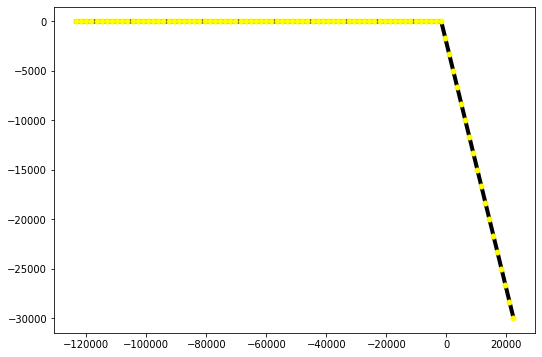

In [20]:
plot_matrix_input(sp, storm_track_list=st_list, case_ini=0, case_end=20);

AttributeError: 'DataFrame' object has no attribute 'move'

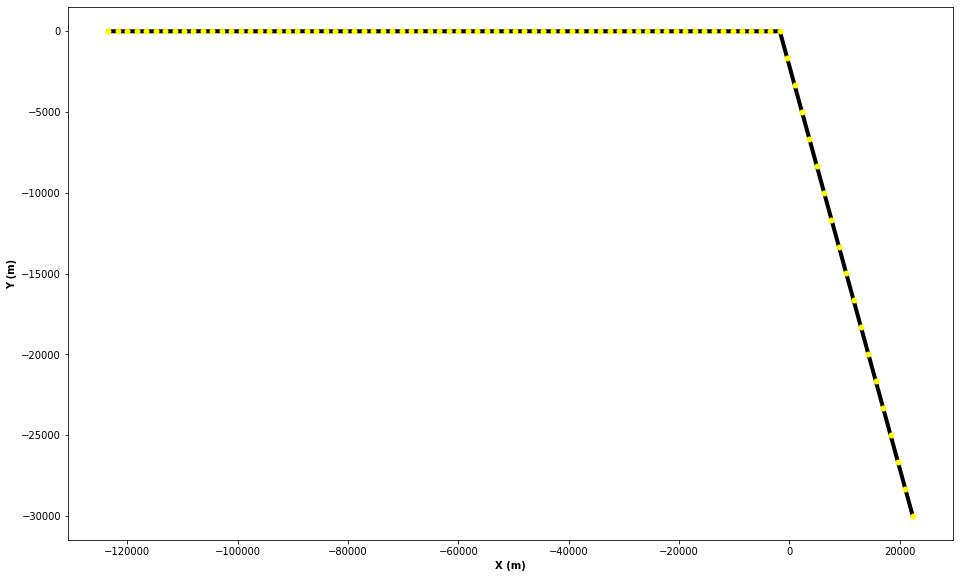

In [22]:
plot_case_input(sp, storm_track_list = [st_list[0]]);

#### <span style="font-family: times, Times New Roman; font-size:15pt; font-style:italic; font-weight:bold; color:blue;">Plot input: Graffiti maximum winds

KeyError: 'X'

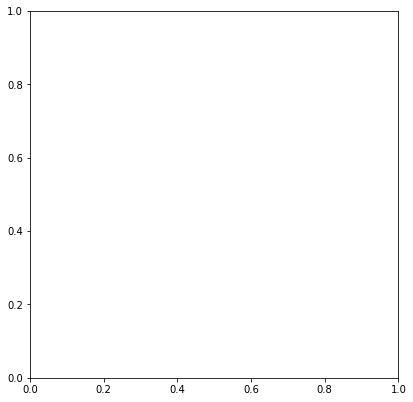

In [23]:
fig = plot_matrix_grafiti(sw, 'W', storm_track_list=st_list, case_ini=0, case_end=20, width=33, height=27);
# fig.savefig(op.join(p_figs, 'grafiti_vortex_matrix.png'))

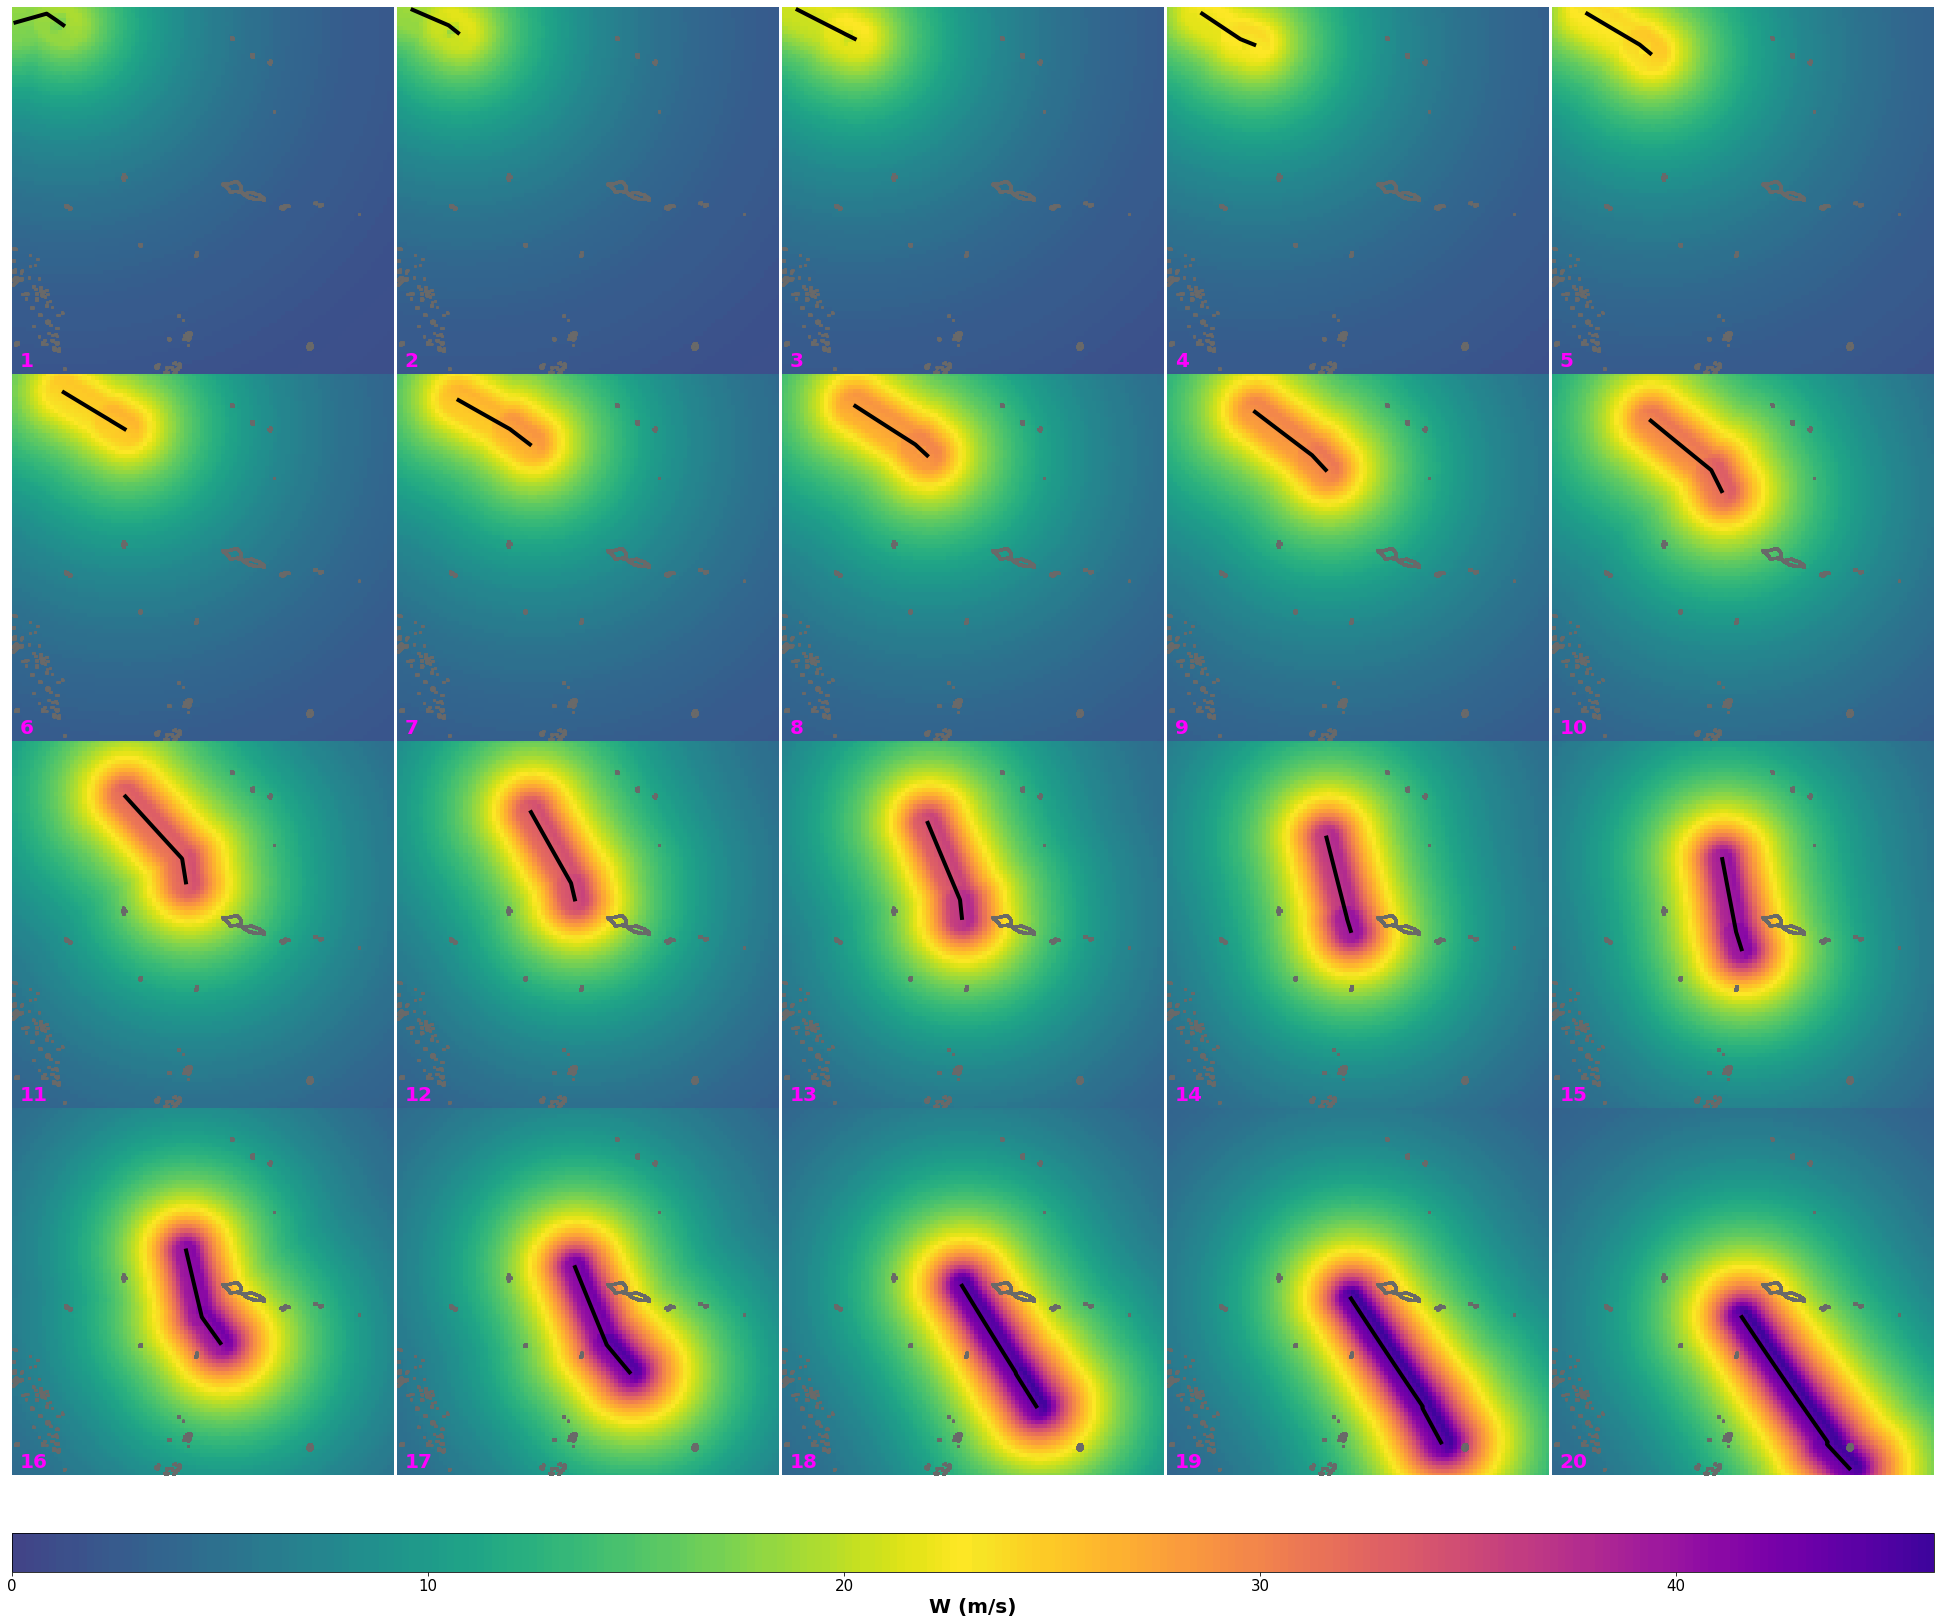

In [28]:
fig = plot_matrix_grafiti(sw, 'W', storm_track_list=st_list, case_ini=1, case_end=21, width=34.5, height=27);
fig.savefig(op.join(p_figs, 'grafiti_vortex_matrix.png'))

###  **4.2 Run cases**

In [23]:
sw.run_cases()

SWAN CASE: 0001 SOLVED
SWAN CASE: 0002 SOLVED
SWAN CASE: 0003 SOLVED
SWAN CASE: 0004 SOLVED
SWAN CASE: 0005 SOLVED
SWAN CASE: 0006 SOLVED
SWAN CASE: 0007 SOLVED
SWAN CASE: 0008 SOLVED
SWAN CASE: 0009 SOLVED
SWAN CASE: 0010 SOLVED
SWAN CASE: 0011 SOLVED
SWAN CASE: 0012 SOLVED
SWAN CASE: 0013 SOLVED
SWAN CASE: 0014 SOLVED
SWAN CASE: 0015 SOLVED
SWAN CASE: 0016 SOLVED
SWAN CASE: 0017 SOLVED
SWAN CASE: 0018 SOLVED
SWAN CASE: 0019 SOLVED


#### <span style="font-family: times, Times New Roman; font-size:15pt; font-style:italic; font-weight:bold; color:blue;">Plot output: Hsig

ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

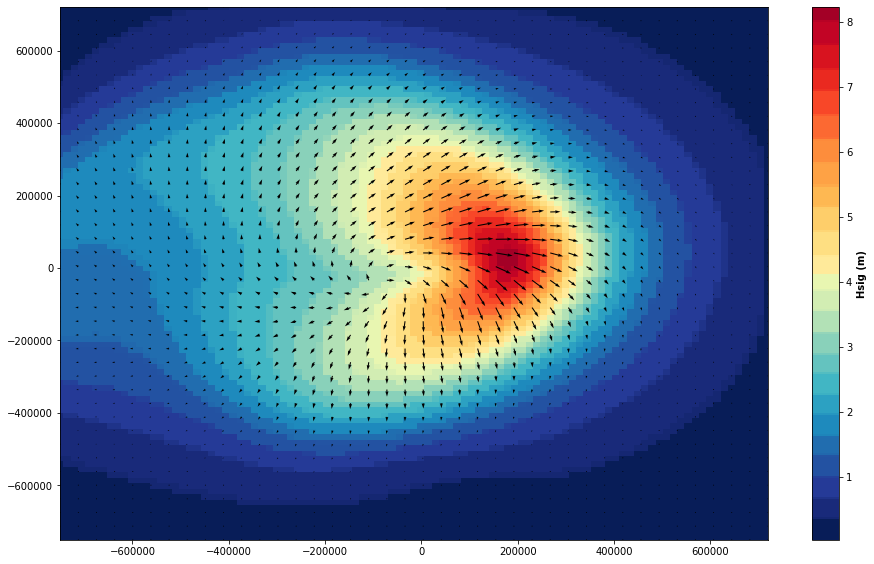

In [24]:
# fig = plot_case_output(sw, storm_track_list = [st], t_num=300);
fig = plot_case_output(sw, case=19, storm_track_list = st_list[19], t_num=24*2+3);

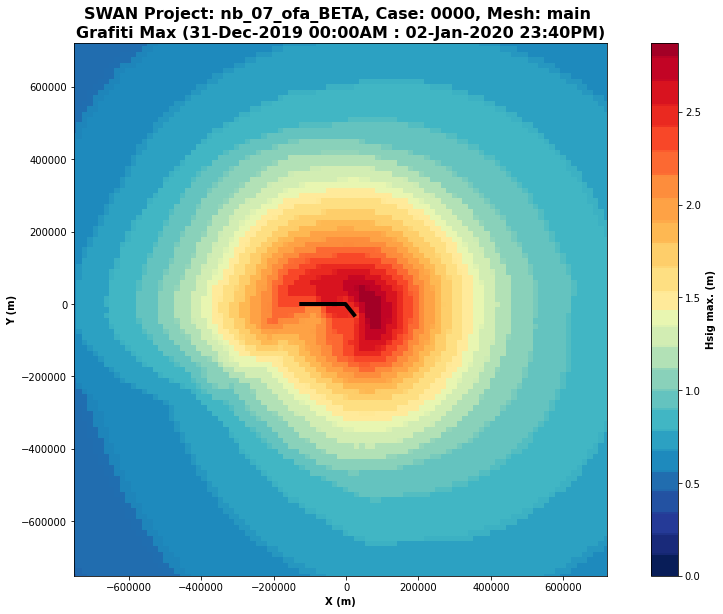

In [20]:
fig = plot_case_output_grafiti(sw, storm_track_list = [st_list[0]]);

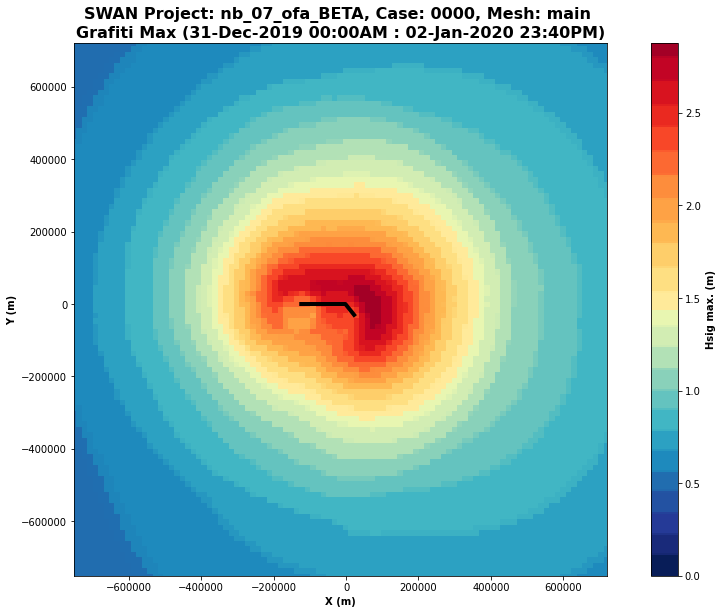

In [46]:
fig = plot_case_output_grafiti(sw, storm_track_list = [st_list[0]]);

In [ ]:
fig = plot_case_output(sw, storm_track_list = [st], t_num=300);

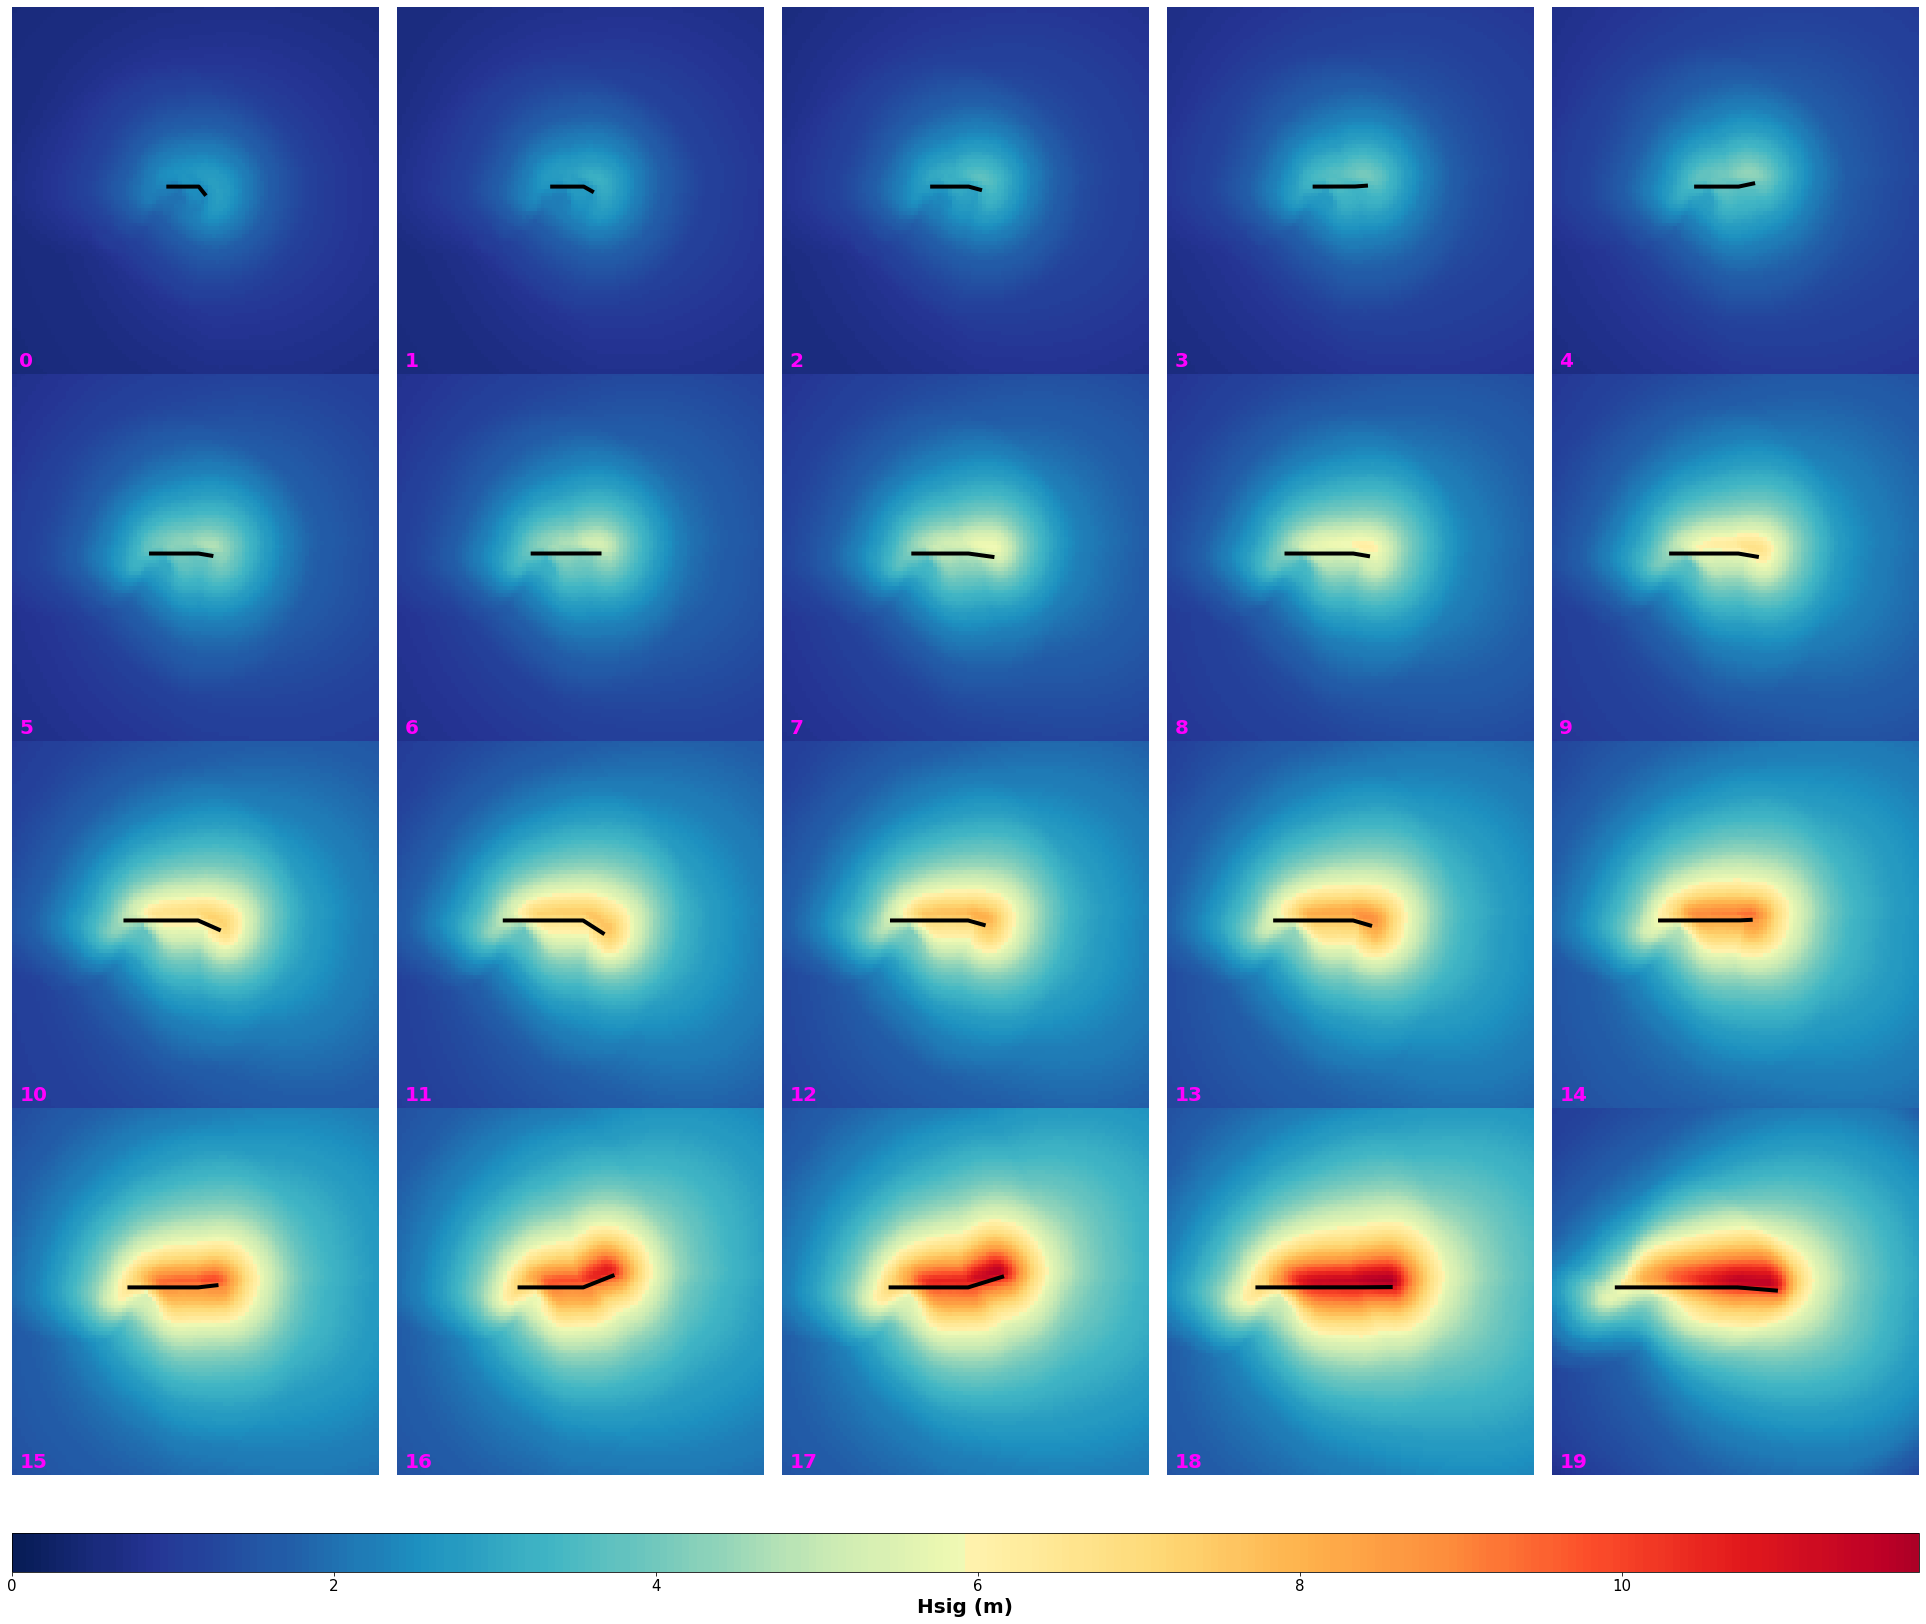

In [17]:
fig = plot_matrix_grafiti(sw, 'Hsig', storm_track_list=st_list, case_ini=0, case_end=20, width=34.5, height=27);
fig.savefig(op.join(p_figs, 'grafiti_output_matrix.png'))

#### <span style="font-family: times, Times New Roman; font-size:15pt; font-style:italic; font-weight:bold; color:blue;">Plot output: Control Point time series

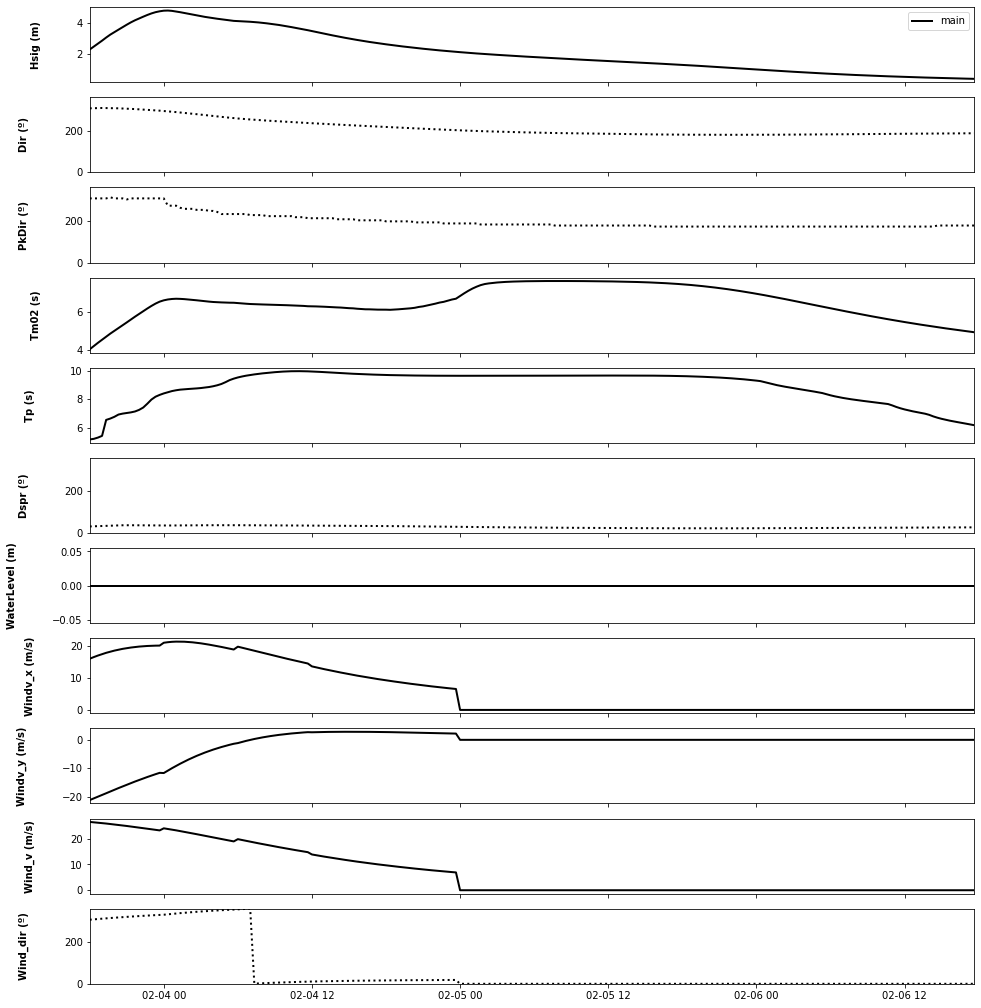

In [20]:
plot_case_output_points(sw, case=19);

###  **4.3 Extract output**

####  **Mesh main**

In [19]:
output_main = sw.extract_output(case_ini=19, case_end=20)
print(output_main[0], '\n')

<xarray.Dataset>
Dimensions:     (X: 99, Y: 99, time: 108)
Coordinates:
  * time        (time) datetime64[ns] 2019-12-31 ... 2020-01-01T11:40:00
  * X           (X) float64 -7.5e+05 -7.35e+05 -7.2e+05 ... 7.05e+05 7.2e+05
  * Y           (Y) float64 -7.5e+05 -7.35e+05 -7.2e+05 ... 7.05e+05 7.2e+05
Data variables:
    PkDir       (time, Y, X) float32 nan nan nan ... 42.500004 42.500004
    Tp          (time, Y, X) float32 nan nan nan ... 13.429804 13.569909
    Dir         (time, Y, X) float32 nan nan nan ... 41.317352 40.890224
    Tm02        (time, Y, X) float32 nan nan nan ... 11.194701 11.347277
    Hsig        (time, Y, X) float32 0.0 0.0 0.0 ... 1.9256989 1.860529
    Dspr        (time, Y, X) float32 nan nan nan ... 8.811451 8.604863 8.361988
    WaterLevel  (time, Y, X) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    Windv_x     (time, Y, X) float32 -5.17 -5.22051 -5.2710204 ... 0.0 0.0 0.0
    Windv_y     (time, Y, X) float32 -0.75 -0.69908166 -0.6079592 ... 0.0 0.0
   

####  **Points (mesh main)**

In [35]:
output_pts = sw.extract_output_points()
print(output_pts, '\n')

<xarray.Dataset>
Dimensions:     (case: 21, point: 4, time: 576)
Coordinates:
  * time        (time) datetime64[ns] 1990-01-30 ... 1990-02-06T23:40:00
Dimensions without coordinates: case, point
Data variables:
    Hsig        (case, point, time) float64 0.1594 0.1563 ... 0.4185 0.4107
    Dir         (case, point, time) float64 233.2 232.8 232.9 ... 90.1 89.83
    PkDir       (case, point, time) float64 232.5 232.5 232.5 ... 97.5 97.5 97.5
    Tm02        (case, point, time) float64 1.299 1.317 1.351 ... 5.698 5.653
    Tp          (case, point, time) float64 1.817 1.844 1.883 ... 8.492 8.449
    Dspr        (case, point, time) float64 31.51 32.36 32.87 ... 26.11 26.39
    WaterLevel  (case, point, time) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    Windv_x     (case, point, time) float64 -1.63 -1.637 -1.642 ... 0.0 0.0 0.0
    Windv_y     (case, point, time) float64 -2.175 -2.176 -2.18 ... 0.0 0.0 0.0
    x_point     (case, point) float64 187.2 190.9 188.2 ... 190.9 188.2 181.4
   

In [40]:
output_pts_spec = sw.extract_output_points_spec()
print(output_pts_spec, '\n')


<xarray.Dataset>
Dimensions:    (case: 21, direction: 72, frequency: 38, point: 4, time: 576)
Coordinates:
  * time       (time) datetime64[ns] 1990-01-30 ... 1990-02-06T23:40:00
  * frequency  (frequency) float64 0.03 0.033 0.0363 ... 0.8273 0.9096 1.0
  * direction  (direction) float64 267.5 262.5 257.5 252.5 ... -77.5 -82.5 -87.5
Dimensions without coordinates: case, point
Data variables:
    lon_pts    (case, point) float64 187.2 190.9 188.2 ... 190.9 188.2 181.4
    lat_pts    (case, point) float64 -13.35 -9.01 -18.62 ... -9.01 -18.62 -18.62
    spec       (case, frequency, direction, point, time) float64 0.0 0.0 ... 0.0
Attributes:
    mesh_ID:  main 



###  **4.4 Analysis**

In [36]:
from hywaves.swan.plots.common import custom_cmap, bathy_cmap

####  **Aggregate segments (POINTS)**

In [37]:
# from 30h segments generate mask to first 6h
mask_pts = np.zeros(output_pts.Hsig.shape)
segment_overlap = 18
segment_step = 18*4   # 4*6h * 20'step
t_i = 18
for i in range(output_pts.case.size):
    if i >= 1:
        mask_pts[i,0,np.arange(t_i, t_i+segment_step)] = np.nan
        t_i += segment_overlap
        
# add mask
output_pts['mask'] = (('case','point','time'), mask_pts)

####  **Aggregate segments (OUTPUT)**

In [38]:
# 48h+6h segments

# obtain common time index
out_concat = xr.concat(output_main[:])  # dim time not specified to align dates
out_concat

<xarray.Dataset>
Dimensions:     (concat_dims: 21, lat: 91, lon: 95, time: 576)
Coordinates:
  * time        (time) datetime64[ns] 1990-01-30 ... 1990-02-06T23:40:00
  * lon         (lon) float64 180.0 180.1 180.3 180.4 ... 192.6 192.7 192.9
  * lat         (lat) float64 -20.0 -19.86 -19.72 ... -7.914 -7.777 -7.639
Dimensions without coordinates: concat_dims
Data variables:
    PkDir       (concat_dims, time, lat, lon) float32 nan nan ... 202.5 202.5
    Hsig        (concat_dims, time, lat, lon) float32 0.0 0.0 ... 0.9528233
    Dir         (concat_dims, time, lat, lon) float32 nan nan ... 206.94348
    Dspr        (concat_dims, time, lat, lon) float32 nan nan ... 10.338257
    Tm02        (concat_dims, time, lat, lon) float32 nan nan ... 7.7774954
    Tp          (concat_dims, time, lat, lon) float32 nan nan ... 9.789982
    WaterLevel  (concat_dims, time, lat, lon) float32 0.0 0.0 0.0 ... 0.0 0.0
    Windv_x     (concat_dims, time, lat, lon) float32 -1.61 -1.6100001 ... 0.0
    Windv

In [39]:
# from 30h-vortex segments generate mask to first 6h-vortex
mask_out = np.zeros(out_concat.Hsig.shape)
segment_overlap = 18
segment_step = 18*4   # 4*6h * 20'step
t_i = 18
for i in range(out_concat.concat_dims.size):
    if i >= 1:
        mask_out[i,np.arange(t_i, t_i+segment_step),:,:] = np.nan
        t_i += segment_overlap
        
# add mask
out_concat['mask'] = (('concat_dims','time','lat','lon'), mask_out)

####  **Aggregate spectra (POINTS)**

In [41]:
# from 30h segments generate mask to first 6h
mask_pts_spec = np.zeros(output_pts_spec.spec.shape)
segment_overlap = 18
segment_step = 18*4   # 4*6h * 20'step
t_i = 18
for i in range(output_pts_spec.case.size):
    if i >= 1:
        mask_pts_spec[i,:,:,:,np.arange(t_i, t_i+segment_step)] = np.nan
        t_i += segment_overlap
        
# add mask
output_pts_spec['mask'] = (('case','frequency','direction','point','time'), mask_pts_spec)

In [33]:
output_pts_spec

<xarray.Dataset>
Dimensions:    (case: 21, direction: 72, frequency: 38, point: 4, time: 576)
Coordinates:
  * time       (time) datetime64[ns] 1990-01-30 ... 1990-02-06T23:40:00
  * frequency  (frequency) float64 0.03 0.033 0.0363 ... 0.8273 0.9096 1.0
  * direction  (direction) float64 267.5 262.5 257.5 252.5 ... -77.5 -82.5 -87.5
Dimensions without coordinates: case, point
Data variables:
    lon_pts    (case, point) float64 187.2 190.9 188.2 ... 190.9 188.2 181.4
    lat_pts    (case, point) float64 -13.35 -9.01 -18.62 ... -9.01 -18.62 -18.62
    spec       (case, frequency, direction, point, time) float64 0.0 0.0 ... 0.0
    mask       (case, frequency, direction, point, time) float64 0.0 0.0 ... 0.0
Attributes:
    mesh_ID:  main

####  **Store**

In [42]:
# store
out_concat.time.attrs=[]    # error because time has no attributes
out_concat.to_netcdf((op.join(p_proj, n_proj, 'output_concat_mask.nc')))
output_pts.to_netcdf((op.join(p_proj, n_proj, 'output_pts_mask.nc')))
output_pts_spec.to_netcdf((op.join(p_proj, n_proj, 'output_pts_spec_mask.nc')))